In [1]:
import numpy as np
import pandas as pd
import neurokit2 as nk

In [2]:
cog_data_dir = "/home/ashish/Documents/github/VA/data/cognitive_data"
phy_data_dir = "/home/ashish/Documents/github/VA/data/physical_data"

- Currently, in Varun's data, there are 10 users with IDs from 0-9
- Each user has either one or two study sessions (session_1 and/or session_2)
- Each session contains multiple blocks of 0-back and 2-back tasks that the user performed.
    - Each block has three sets of data collected in different CSV files
        1. Score obtained (0-100) in the played session
            - Inside the block dir with ".csv" extension
        2. BiosignalPlux data (BSP) - ECG, GSR, Breathing, EMG, PulOxR, PulOxIR
            - Inside "block_x_x/bsp" dir with ".csv" extension
        3. EEG data
            - File inside "block_x_x/eeg" with no extension

## Collect all Cognitive Fatigue data into one Pandas DataFrame for all users

In [3]:
import os
from csv import reader

In [4]:
def get_n_back_score(block_dir):
    # return the final score (float from 0.0-1.0) of the N-back task that the user played (0-100)
    n_back_file = None
    for content in os.listdir(block_dir):
        if ".csv" in content:
            n_back_file = content
            break
    if not n_back_file:
        return 0
    
    with open(os.path.join(block_dir, n_back_file), "r") as file:
        csv_reader = reader(file)
        last_row = list(csv_reader)[-1]
        
    # Example row: ['3_Letter_C.png', '', '11', '0', '67', '1', '97.46835443037975', '0.0']
    # Second last column of the last row represents the final score in the game
    return round(float(last_row[-2]) / 100, 2)

In [65]:
def get_ecg_features(bsp_data):
    ecg_data = bsp_data['ECG'].values
    signals, info = nk.ecg_process(ecg_data, sampling_rate=1000)
    peaks, p_info = nk.ecg_peaks(ecg_data, sampling_rate=1000)
    nk.ecg_plot(signals, sampling_rate=1000)
    # Select only four features from the signals (others seem to be zero for some reason)
    ecg_features = signals[["ECG_Raw", "ECG_Clean", "ECG_Rate", "ECG_Quality"]]
    
    # Also, compute HRV indices
    hrv_features = nk.hrv(peaks, sampling_rate=1000, show=True)
    return ecg_features, hrv_features

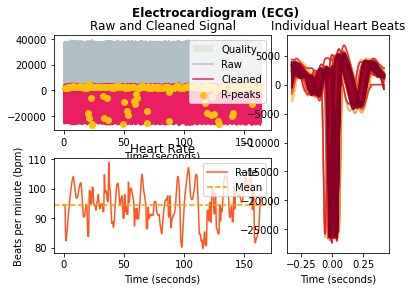

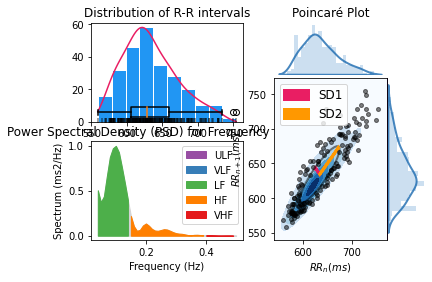

In [66]:
e, h = get_ecg_features(bsp_features)

In [70]:
# To extract relevant HRV Features, following techniques can be used:
# 1. Pearson's Correlation
# 2. Recursive Feature Elimination (RFE)
# 3. Extra Tree Classifier

h.columns

Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_SDANN1', 'HRV_SDNNI1', 'HRV_SDANN2',
       'HRV_SDNNI2', 'HRV_SDANN5', 'HRV_SDNNI5', 'HRV_RMSSD', 'HRV_SDSD',
       'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN',
       'HRV_IQRNN', 'HRV_pNN50', 'HRV_pNN20', 'HRV_HTI', 'HRV_TINN', 'HRV_ULF',
       'HRV_VLF', 'HRV_LF', 'HRV_HF', 'HRV_VHF', 'HRV_LFHF', 'HRV_LFn',
       'HRV_HFn', 'HRV_LnHF', 'HRV_SD1', 'HRV_SD2', 'HRV_SD1SD2', 'HRV_S',
       'HRV_CSI', 'HRV_CVI', 'HRV_CSI_Modified', 'HRV_PIP', 'HRV_IALS',
       'HRV_PSS', 'HRV_PAS', 'HRV_GI', 'HRV_SI', 'HRV_AI', 'HRV_PI', 'HRV_C1d',
       'HRV_C1a', 'HRV_SD1d', 'HRV_SD1a', 'HRV_C2d', 'HRV_C2a', 'HRV_SD2d',
       'HRV_SD2a', 'HRV_Cd', 'HRV_Ca', 'HRV_SDNNd', 'HRV_SDNNa',
       'HRV_DFA_alpha1', 'HRV_DFA_alpha1_ExpRange', 'HRV_DFA_alpha1_ExpMean',
       'HRV_DFA_alpha1_DimRange', 'HRV_DFA_alpha1_DimMean', 'HRV_DFA_alpha2',
       'HRV_DFA_alpha2_ExpRange', 'HRV_DFA_alpha2_ExpMean',
       'HRV_DFA_alpha2_DimRange', 'HRV_DFA

In [33]:
def get_eda_features(bsp_data):
    eda_data = bsp_data['GSR'].values
    signals, info = nk.eda_process(eda_data, sampling_rate=1000)
    nk.eda_plot(signals, sampling_rate=1000)
    # Select only four features from the signals (others seem to be zero for some reason)
    # EDA_Phasic seems to be an irrelevant feature, but considering it for now (may want to look at other samples too)
    eda_features = signals[["EDA_Raw", "EDA_Clean", "EDA_Tonic", "EDA_Phasic"]]
    return eda_features

/tankpool/home/ashish/.virtualenvs/VA/lib/python3.6/site-packages/neurokit2/eda/eda_clean.py:54: NeuroKitWarning: There are 1 missing data points in your signal. Filling missing values by using the forward filling method.
  category=NeuroKitWarning


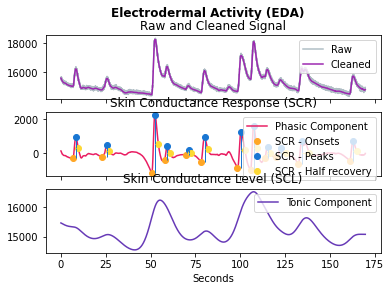

,EDA_Raw,EDA_Clean,EDA_Tonic,EDA_Phasic
0,15603.0,15611.606783,15468.044357,143.562428
1,15591.0,15611.453779,15468.010666,143.443116
2,15582.0,15611.299542,15467.976974,143.322571
3,15575.0,15611.144069,15467.943282,143.200790
4,15583.0,15610.987356,15467.909589,143.077770
...,...,...,...,...
169630,14887.0,14825.431652,15082.756823,-1.175316
169631,14887.0,14825.431908,15082.756823,-1.085033
169632,14877.0,14825.432115,15082.756823,-0.994783
169633,14873.0,14825.432280,15082.756823,-0.904561


In [51]:
get_eda_features(bsp_features)

In [37]:
def get_rsp_features(bsp_data):
    rsp_data = bsp_data['Breathing'].values
    signals, info = nk.rsp_process(rsp_data, sampling_rate=1000)
    nk.rsp_plot(signals, sampling_rate=1000)
    # Select only four features from the signals (others seem to be zero for some reason)
    rsp_features = signals[["RSP_Raw", "RSP_Clean", "RSP_Amplitude", "RSP_Rate"]]
    return rsp_features

/tankpool/home/ashish/.virtualenvs/VA/lib/python3.6/site-packages/neurokit2/rsp/rsp_clean.py:63: NeuroKitWarning: There are 1 missing data points in your signal. Filling missing values by using the forward filling method.
  category=NeuroKitWarning


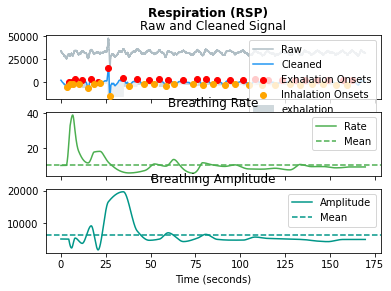

,RSP_Raw,RSP_Clean,RSP_Amplitude,RSP_Rate
0,34140.0,2138.818944,5179.911638,9.964867
1,34053.0,2137.578078,5179.911638,9.964867
2,34192.0,2136.324327,5179.911638,9.964867
3,34228.0,2135.057765,5179.911638,9.964867
4,34108.0,2133.778464,5179.911638,9.964867
...,...,...,...,...
169630,31734.0,0.760033,5040.653153,9.090909
169631,31767.0,0.655589,5040.653153,9.090909
169632,31825.0,0.560277,5040.653153,9.090909
169633,31684.0,0.473856,5040.653153,9.090909


In [50]:
get_rsp_features(bsp_features)

In [64]:
def get_emg_features(bsp_data):
    emg_data = bsp_data['EMG'].values
    signals, info = nk.emg_process(emg_data, sampling_rate=1000)
    # nk.emg_plot(signals, sampling_rate=1000)
    # Select only four features from the signals (others seem to be zero for some reason)
    emg_features = signals[["EMG_Raw", "EMG_Clean", "EMG_Amplitude", "EMG_Activity"]]
    return emg_features

/tankpool/home/ashish/.virtualenvs/VA/lib/python3.6/site-packages/neurokit2/events/events_find.py:93: NeuroKitWarning: No events found. Check your event_channel or adjust 'threshold' or 'keep' arguments.
  category=NeuroKitWarning,


KeyError: -1

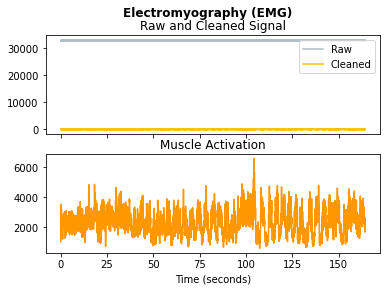

In [62]:
get_emg_features(bsp_features)

In [6]:
def extract_eeg_features(block_dir):
    # Return as Pandas DF containing all relevant EEG features useful for the dataset
    eeg_dir = os.path.join(block_dir, "eeg")
    eeg_file_name = os.listdir(eeg_dir)[0]
    eeg_file_path = os.path.join(eeg_dir, eeg_file_name)
    eeg_data = pd.read_csv(eeg_file_path, delimiter=" ", names=["Type", "1", "2", "3", "4"])
    return eeg_data

In [7]:
def extract_bsp_features(block_dir):
    # Return as Pandas DF containing all relevant BSP (ECG, GSR, Breathing, EMG, PulOxR, PulOxlR)
    bsp_dir = os.path.join(block_dir, "bsp")
    bsp_file_name = os.listdir(bsp_dir)[0]
    bsp_file_path = os.path.join(bsp_dir, bsp_file_name)
    bsp_data = pd.read_csv(bsp_file_path)
    return bsp_data

In [59]:
session_counter = 0
for user_id in range(9, 10):
    user_dir = os.path.join(cog_data_dir, f"user_{user_id}")
    for session in os.listdir(user_dir):
        session_dir = os.path.join(user_dir, session)
        for block in os.listdir(session_dir):
            # Sanity check if the directory has the name "block" or not
            if "block" not in block or "practice" in block.lower():
                # Ignore directories other than block
                continue
            block_dir = os.path.join(session_dir, block)
            # For each block, we want to extract three different sets of data
            score = get_n_back_score(block_dir)
            print(f"{session_counter+1}. Score: {score} | Session: {session[-1]} | User_ID: {user_id}")
            session_counter += 1
            eeg_features = extract_eeg_features(block_dir)
            bsp_features = extract_bsp_features(block_dir)
            break
        break
    break

1. Score: 1.0 | Session: 1 | User_ID: 9


In [44]:
bsp_features

,Time,ECG,GSR,Breathing,EMG,PulOxR,PulOxIR
0,12:58:10.744184,24132.0,5204.0,21110.0,32757.0,0.0,0.0
1,12:58:10.760462,24140.0,5213.0,21182.0,32628.0,0.0,0.0
2,12:58:10.760488,24156.0,5262.0,21215.0,32671.0,24639.0,9309.0
3,12:58:10.760508,24150.0,5337.0,21136.0,32720.0,24639.0,9309.0
4,12:58:10.763012,24177.0,5211.0,21180.0,32734.0,25517.0,9334.0
...,...,...,...,...,...,...,...
165176,13:00:55.831399,32893.0,4465.0,31908.0,32762.0,25563.0,9212.0
165177,13:00:55.831417,32918.0,4463.0,31901.0,32824.0,25562.0,9212.0
165178,13:00:55.831554,32920.0,4492.0,31945.0,32786.0,25562.0,9212.0
165179,13:00:55.831572,32940.0,4475.0,31806.0,32679.0,25563.0,9210.0


In [30]:
eeg_features

,Type,1,2,3,4
0,eeg,967.248413,810.975281,832.360046,908.029175
1,eeg,972.183411,838.940002,822.490173,901.449219
2,eeg,972.183411,746.821106,835.650024,924.478943
3,eeg,950.798645,822.490173,829.070068,911.319092
4,eeg,955.733582,809.330322,829.070068,909.674133
...,...,...,...,...,...
66404,ts,0.272727,0.315789,0.707317,0.000000
66405,eeg,829.070068,837.294983,825.780151,863.614685
66406,eeg,835.650024,830.715088,825.780151,863.614685
66407,eeg,830.715088,858.679749,824.135132,866.904663
